To run this file upload the data.tsv file into a folder "data"(i.e data/data.tsv) and run the code block in order.

In [1]:
import sys
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tabulate import tabulate

In [2]:
# TextDataset is Described in Section 3.3 of Assignment 2
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [3]:
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [4]:
def createDatasets(df):
    train, test = train_test_split(df[['text', 'label']], test_size=0.2, random_state=0, stratify=df[['label']])

    trainFinal, val = train_test_split(train, test_size=0.2, random_state=0, stratify=train['label'])

    #writing to train, val and test tsv
    trainFinal.to_csv('data/train.tsv', sep="\t", index=False)
    test.to_csv('data/test.tsv', sep="\t", index=False)
    val.to_csv('data/validation.tsv', sep="\t", index=False)

    #creating overfit dataset and writing to tsv
    s0 = trainFinal.label[df.label.eq(0)].sample(25).index
    s1 = trainFinal.label[df.label.eq(1)].sample(25).index 

    overfit = trainFinal.loc[s0.union(s1)]
    overfit.to_csv('data/overfit.tsv', sep="\t", index=False)


In [5]:
def print_closest_cosine_words(glove, vec, n=5):
    cosine_words = []
    dists = torch.cosine_similarity(vec, glove.vectors) 
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1], reverse=True)
    for idx, difference in lst[1:n+1]:   
        cosine_words.append(glove.itos[idx] + " - %5.2f" % difference)
    return cosine_words

In [6]:
def main(batch_size):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #read data.tsv and splitting to train (64%), test (20%), val (16%)
    df = pd.read_csv("data/data.tsv", sep='\t')
    createDatasets(df)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
    overfit_dataset = TextDataset(glove, "overfit")
        
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    overfit_dataloader = torch.utils.data.DataLoader(
        dataset=overfit_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))
    
    predictionBaselineModel = trainBaselineModel(train_dataloader, validation_dataloader,test_dataloader, overfit_dataloader, glove, 100, batch_size, 50, 0.001)
    torch.save(predictionBaselineModel, 'model_{}.pt'.format("Baseline"))
    for name, param in predictionBaselineModel.named_parameters():
      mydata = [
          [name, [i for i in print_closest_cosine_words(glove, param.data, n=20)]]
      ]
      # create header
      head = ["word", "Cosine Similarity"]

      # display table
      temp = tabulate(mydata, headers=head, tablefmt="grid")
      print(temp)

    # Instantiate your model(s) and train them and so on 
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

In [7]:
class Baseline(nn.Module):
  def __init__(self, embedding_dim, vocab):
    super(Baseline, self).__init__()
    self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
    self.fc = nn.Linear(embedding_dim, 1)

  def forward(self, x, lengths=None):
    #x has shape [sentence length, batch size]
    embedded = self.embedding(x)
    average = embedded.mean(0) # [sent len, batch size, emb dim]
    output = self.fc(average)
    output = torch.sigmoid(output)
    return output

In [8]:
def evaluate(model, dataLoader, criterion, batch_size):
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        total_corr = 0
        p =0
        for index,context in iter(dataLoader):
            index = index.type(torch.long)
            context = context.type(torch.float)
            logits = model(index)
            loss = criterion(logits.squeeze(), context)
            test_loss += float(loss)/batch_size
            p += 1
            corr = (logits > 0.5).squeeze().long() == context
            total_corr += int(corr.sum())
    return test_loss, total_corr, p

In [9]:
def trainBaselineModel(train_dataloader, validation_dataloader, test_dataloader, overfit_dataloader, vocab, embedding_size, batch_size, epochs, lr):
    model = Baseline(100, vocab)
    criterion = torch.nn.BCEWithLogitsLoss()
    opt_func = torch.optim.Adam
    optimizer = opt_func(model.parameters(), lr)       

    train_loss_list = []
    val_loss_list = []
    test_loss_list = []
    overfit_loss_list = []
    train_acc = []
    val_acc = []
    test_acc = []
    overfit_acc = []

    #train model using train set
    iters = np.arange(0,epochs)
    for epoch in range(epochs):
        train_loss= 0.0
        total_corr = 0
        model.train()
        n = 0
        for index,context in iter(train_dataloader): 
            index = index.type(torch.long)
            context = context.type(torch.float)
            logits = model(index)
            loss = criterion(logits.squeeze(), context)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss = train_loss + float(loss)/batch_size
            n += 1
            corr = (logits > 0.5).squeeze().long() == context
            total_corr += int(corr.sum())
        train_loss_list.append(train_loss/n)
        train_acc.append(float(total_corr) / len(train_dataloader.dataset))

        #evaluate validation set
        val_loss, total_corr, p = evaluate(model, validation_dataloader, criterion, batch_size)
        val_loss_list.append(val_loss/p) 
        val_acc.append(float(total_corr) / len(validation_dataloader.dataset))

        #evaluate test set
        test_loss, total_corr, p = evaluate(model, test_dataloader, criterion, batch_size)
        test_loss_list.append(test_loss/p) 
        test_acc.append(float(total_corr) / len(test_dataloader.dataset))

        #evaluate overfit set
        overfit_loss, total_corr, p = evaluate(model, overfit_dataloader, criterion, batch_size)
        overfit_loss_list.append(overfit_loss/p) 
        overfit_acc.append(float(total_corr) / len(overfit_dataloader.dataset))

    print("Validation Accuracy: " + str(val_acc[-1]), "Validation Loss: " + str(val_loss_list[-1]))

    print("Test Accuracy: " + str(test_acc[-1]), "Test Loss: " + str(test_loss_list[-1]))
    print("Overfit Accuracy: " + str(overfit_acc[-1]), "Overfit Loss: " + str(overfit_loss_list[-1]))

    #plot loss curve
    plt.title("Loss Curve")
    plt.plot(iters, train_loss_list, label="Train")
    plt.plot(iters, val_loss_list, label="Validation")
    plt.plot(iters, overfit_loss_list, label="Overfit")
    plt.plot(iters, test_loss_list, label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    #plot Accuracy curve
    plt.title("Accuracy Curve")
    plt.plot(iters, train_acc, label="Train accuracy")
    plt.plot(iters, val_acc, label="Validation accuracy")
    plt.plot(iters, overfit_acc, label="Overfit accuracy")
    plt.plot(iters, test_acc, label="Test accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
    return model

.vector_cache/glove.6B.zip: 862MB [02:39, 5.42MB/s]                           
100%|█████████▉| 399999/400000 [00:12<00:00, 31609.39it/s]


Validation Accuracy: 0.875625 Validation Loss: 0.0575978124514222
Test Accuracy: 0.879 Test Loss: 0.057703558400273296
Overfit Accuracy: 0.92 Overfit Loss: 0.05674492120742798


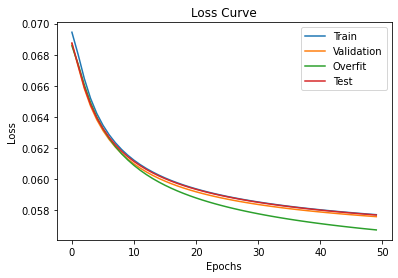

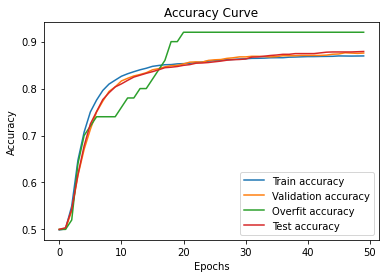

+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| word             | Cosine Similarity                                                                                                                                                                                                                                                                                                                                                                                     |
+==================+==========================================================================================================================================================

In [10]:
if __name__ == '__main__':
    main(10)

Provide the training loss and accuracy plot for the overfit data in your Report.

We can see above the overfit plot for training and accuracy. The loss is less when compared to other plots and the accuracy is also high for the overfit data.